In [130]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [131]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [132]:
NEG_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/negative'
POS_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/positive'
ANC_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/anchor'

In [133]:
# Negative dataset : https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
for directory in os.listdir('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled'):
    for file in os.listdir(os.path.join('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled', directory)):
        EX_PATH = os.path.join('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


In [80]:
# Random but unique name for img
import uuid

In [ ]:
# Use camera
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #250x250 pixel
    frame = frame[ 200:200+250, 170:170+250, :]
    
    #Collect anchor
    if cv2.waitKey(1) == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #Collect positive
    if cv2.waitKey(1) == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        

    #Show image
    cv2.imshow('IMAGE', frame)
    
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [81]:
anchor = tf.data.Dataset.list_files(ANC_PATH +'/*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH +'/*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH +'/*.jpg').take(500)

In [82]:
img_test = anchor.as_numpy_iterator()
print(img_test.next())

b'/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/2c29655b-7413-11ef-98eb-e81f155e7428.jpg'


In [83]:
def preprocess(file_path):
    read_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(read_img)

    img = tf.image.resize(img, (105,105))
    img = img/255.0
    return img

In [84]:
img = preprocess('/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/36d5c573-7413-11ef-99be-e81f155e7428.jpg')

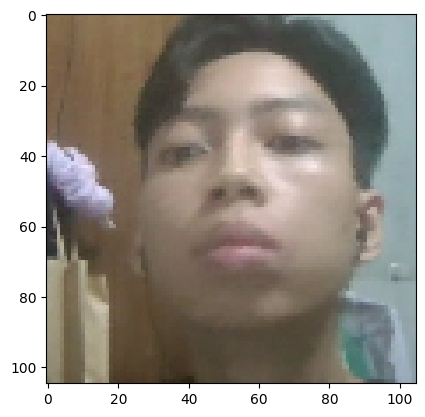

In [85]:
plt.imshow(img)

In [86]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [87]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [88]:
try_img = data.as_numpy_iterator()
try_img = try_img.next()
try_img

(b'/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/c872ddb1-7413-11ef-ab52-e81f155e7428.jpg',
 b'/home/leloc/Documents/USTH-B3/Group_project/Model/positive/aacb0030-7413-11ef-ab47-e81f155e7428.jpg',
 np.float32(1.0))

In [89]:
def double_check(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


In [90]:
res = double_check(*try_img)
res

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.49439776, 0.39243695, 0.26059756],
         [0.5319261 , 0.42717087, 0.30614248],
         [0.52204657, 0.41616422, 0.29974213],
         ...,
         [0.6240896 , 0.7028945 , 0.72427636],
         [0.61848074, 0.7008337 , 0.7204415 ],
         [0.6171802 , 0.69953316, 0.719141  ]],
 
        [[0.5002734 , 0.4019541 , 0.2851474 ],
         [0.52494997, 0.41934773, 0.3140256 ],
         [0.5213819 , 0.4141323 , 0.31400558],
         ...,
         [0.627451  , 0.70980394, 0.7294118 ],
         [0.62302923, 0.70590234, 0.7257703 ],
         [0.6120448 , 0.7058824 , 0.7221288 ]],
 
        [[0.49534258, 0.39692986, 0.2892735 ],
         [0.5158063 , 0.41739365, 0.3181406 ],
         [0.50995284, 0.4107376 , 0.32037258],
         ...,
         [0.627451  , 0.70802987, 0.7311858 ],
         [0.6214686 , 0.70603573, 0.7311858 ],
         [0.6210084 , 0.7058824 , 0.7311858 ]],
 
        ...,
 
        [[0.54257697, 0.5186741 

In [129]:
#build pipline
data = data.map(double_check)
data = data.cache()
data = data.shuffle(buffer_size=2000)

TypeError: in user code:

    File "/tmp/ipykernel_10998/3114114138.py", line 2, in double_check  *
        return(preprocess(input_img), preprocess(validation_img), label)
    File "/tmp/ipykernel_10998/3834057882.py", line 2, in preprocess  *
        read_img = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [92]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [93]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [126]:
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = data.batch(16)
test_data = data.prefetch(8)
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

## Model

In [95]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [96]:
embed = make_embedding()
embed.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Siamese L1 Distance class
class L1Dist(tf.keras.layers.Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, inputs):
        input_embedding,validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [98]:
def make_siames_model():
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape=(105,105,3))

    siamese_layer = L1Dist()
    siamese_layer.name = 'distance'
    distances = siamese_layer([embed(input_image), embed(validation_image)])

    classifier = Dense(1, activation ='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'Siamese_Network')


In [99]:
siamese_model = make_siames_model()

siamese_model.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Trainning


### Set up loss and optimize

In [100]:
binary_cross_loss = tf._losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [101]:
checkpoint_dir = './home/leloc/Documents/USTH-B3/Group_project/Model/trainning_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model =siamese_model)


In [102]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
      dtype=float32)

In [103]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Tách batch thành đầu vào và nhãn
        X = batch[:2]
        y = batch[2]

        # Dự đoán đầu ra từ mô hình
        y_pred = siamese_model(X, training=True)

        # Tính toán mất mát
        loss = binary_cross_loss(y, y_pred)
        print(loss)

    # Tính gradient đối với các tham số có thể huấn luyện
    gradients = tape.gradient(loss, siamese_model.trainable_variables)

    # Áp dụng các gradient vào mô hình
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss

        

In [104]:
from tensorflow.keras.metrics import Precision, Recall

In [105]:
def train(data, EPOCH):
    for epoch in range (1, EPOCH + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCH))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            y_pred = siamese_model.predict(batch[:2])
            r.update_state(batch[2], y_pred)
            p.update_state(batch[2], y_pred)
            progbar.update(idx+1)
    print(loss.numpy(), r.result().numpy(), p.result().numpy())

    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

In [106]:
EPOCH = 10

In [107]:
train(train_data, EPOCH)


 Epoch 1/10
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)


/home/leloc/anaconda3/envs/facial_reg/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [117]:
# call model, thử predict -> dimension, test function squeeze, unsqueeze xem biến đổi output nnao

print(test_input.shape) 
print(test_val.shape)

(105, 105, 3)
(105, 105, 3)


In [127]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [134]:
siamese_model.compile(
    optimizer='adam',  # Hoặc bạn có thể chọn các optimizer khác như SGD
    loss='binary_crossentropy',  # Hàm mất mát phù hợp với bài toán phân loại nhị phân
    metrics=['accuracy']  # Các chỉ số bạn muốn theo dõi (accuracy, precision, recall, etc.)
)

y_hat = siamese_model.predict([test_input, test_val])



ValueError: Input 0 of layer "Siamese_Network" is incompatible with the layer: expected shape=(None, 105, 105, 3), found shape=(32, 105, 3)

In [135]:
y_true

np.float32(0.0)

In [136]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

NameError: name 'y_hat' is not defined

In [137]:
siamese_model.save('/home/leloc/Documents/USTH-B3/Group_project/Model/siamesemodel.h5')